## Semi Superviser General Adversarial Network

This is an example of a Semig supervised Gan. This particular method is failing to

In [1]:
from __future__ import print_function, division
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as K

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import logging
# base logger setup, to standardize logging across classes
try:
    logger.debug('testing logger')
except:
    name = 'SGAN'
    formatter = logging.Formatter(fmt='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    handler = logging.StreamHandler()
    handler.setFormatter(formatter)
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)
    logger.addHandler(handler)
    
def create_generator(n_real_inputs, n_hidden_nodes, n_fake_inputs):
    inputs = Input(shape=[n_fake_inputs])
    dense_layer0 = Dense(n_hidden_nodes, kernel_initializer='glorot_normal')(inputs)
    activation_layer0 = Activation('relu')(dense_layer0)
    dense_layer1 =  Dense(n_real_inputs, kernel_initializer='glorot_normal')(activation_layer0) 
    outputs = Activation('sigmoid')(dense_layer1)
    generator = Model(inputs, outputs)
    generator.compile(loss='categorical_crossentropy', optimizer='adam')
    return generator

def create_discriminator(n_real_inputs, n_hidden_nodes, n_outputs, dropout_rate):
    inputs = Input(shape=[n_real_inputs])
    noise = GaussianNoise(.1)(inputs)
    dense_layer0 = Dense(n_hidden_nodes, kernel_initializer='glorot_normal')(noise)
    activation_layer0 = Activation('relu')(dense_layer0)
    drop0 = Dropout(dropout_rate)(activation_layer0)
    dense_layer1 =  Dense(n_outputs + 1, kernel_initializer='glorot_normal')(drop0) 
    outputs = Activation('softmax')(dense_layer1)
    discriminator  = Model(inputs, outputs)
    discriminator.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])
    return discriminator

# Create a stacked version of the model with the generator wieghts frozen
def create_stacked_model(generator, discriminator):
    stacked_model = Sequential()
    generator.trainable = False
    stacked_model.add(generator)
    stacked_model.add(discriminator)
    stacked_model.compile(loss='categorical_crossentropy', optimizer='adam')
    return stacked_model


# define the training functions
def create_training_data(X_train, y_train, generator, batch=10):
    n_obs, n_inputs = X_train.shape
    half_batch = int(batch/2)
    n_fake_inputs = generator.get_input_shape_at(0)[1]
    
    # randomly sample real data 
    index =  np.random.randint(0, n_obs, half_batch)
    real_data = X_train[index, :]
    real_class_labels = y_train[index, :]
    
    # generate fake data 
    noise = np.random.normal(0, 1, (half_batch, n_fake_inputs))
    fake_data =  generator.predict(noise)
    
    # stack real and fake data 
    combined_data = np.concatenate((real_data, fake_data))
    
    #pad labels with zero rows
    labels_padded = np.vstack((real_class_labels, np.zeros(real_class_labels.shape)))
    logger.debug('labels padded shape {}'.format(labels_padded.shape))
    
    # create the real vs fake label
    real_fake_labels = np.reshape(np.append(np.zeros(half_batch), np.ones(half_batch)), (-1,1))
    logger.debug('real vs fake_labels {}'.format(real_fake_labels.shape))
    
    labels = np.hstack((labels_padded, real_fake_labels))
    
    logger.debug('real data shape {}'.format(real_data.shape))
    logger.debug('labels shape {}'.format(labels.shape))
    logger.debug('fake data shape {}'.format(fake_data.shape))

    return real_data, fake_data, labels 

def get_miss_labeled(noise):
    output = np.ones(noise.shape)
    return np.hstack((output, np.zeros((noise.shape[0], 1))))


# primary training functions
def training(X_train, y_train, generator, discriminator, epochs=10, batch=10):
    # create the stacked model
    stacked_model = create_stacked_model(generator, discriminator)
    
    # get the input data shape
    n_obs, n_inputs = X_train.shape
    half_batch = int(batch/2)
    n_fake_inputs = generator.get_input_shape_at(0)[1]
    n_outputs = y_train.shape[1]
    for e in range(epochs):
        real_data, fake_data, labels = create_training_data(X_train, y_train, generator, batch)
        combined_data = np.concatenate((real_data, fake_data))

        # discriminator loss 
        disc_loss = discriminator.train_on_batch(combined_data, labels)
        
        # create noise to 
        noise =  np.random.uniform(0, 1, (int(batch/n_outputs), n_fake_inputs))
        
        # create misslabeled data to force the stack model to learn
        y_mislabled =  get_miss_labeled(noise)
    
        # genertor loss 
        gen_loss = stacked_model.train_on_batch(x=noise,y=y_mislabled)
        logger.info('epoch:{0}/{1}, disc_loss: {2}, gen_loss:{3}'.format(e, epochs, disc_loss, gen_loss))

    generator = stacked_model.layers[0]
    discriminator = stacked_model.layers[1]
    return generator, discriminator


Using TensorFlow backend.
/home/matthew/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/matthew/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/matthew/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/matthew/.local/lib/python3.6/site-packages/tensorflow/py

In [2]:
X_train = load_iris()['data']
scaler = StandardScaler().fit(X_train )
X = scaler.transform(X_train)
y = to_categorical(load_iris()['target'])  ## one hot encodes the integer classes 
feature_names = load_iris()['feature_names'] 
class_names = list(load_iris()['target_names'])
logger.info('X shape {}'.format(X.shape))
logger.info('y shape {}'.format(y.shape))
print(class_names)

2019-10-07 14:42:18,415 - SGAN - INFO - X shape (150, 4)
2019-10-07 14:42:18,416 - SGAN - INFO - y shape (150, 3)


['setosa', 'versicolor', 'virginica']


In [3]:
#num columns in input data
n_real_inputs = X.shape[1]

# number of class labels
n_outputs = y.shape[1]

# length of array used to generate examples
n_fake_inputs = n_outputs 

# number of hidden nodes in distriminator and generator
n_hidden_nodes = 20

batch = 50
epochs = 100

# define generator
generator = create_generator(n_real_inputs, n_hidden_nodes, n_fake_inputs)
generator.summary()

# define discriminator
discriminator = create_discriminator(n_real_inputs, n_hidden_nodes, n_outputs, dropout_rate=.1 )
discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                80        
_________________________________________________________________
activation_1 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 84        
_________________________________________________________________
activation_2 (Activation)    (None, 4)                 0         
Total params: 164
Trainable params: 164
Non-trainable params: 0
_________________________________________________________________
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape   

In [4]:
stacked_model = create_stacked_model(generator, discriminator)
stacked_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 4)                 164       
_________________________________________________________________
model_2 (Model)              (None, 4)                 184       
Total params: 348
Trainable params: 184
Non-trainable params: 164
_________________________________________________________________


In [5]:
## Test out the training creation Function
real_data, fake_data, labels = create_training_data(X, y, generator, batch=10)
pd.DataFrame(labels, columns =class_names + ['real_or_fake'])

,setosa,versicolor,virginica,real_or_fake
0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0
5,0.0,0.0,0.0,1.0
6,0.0,0.0,0.0,1.0
7,0.0,0.0,0.0,1.0
8,0.0,0.0,0.0,1.0
9,0.0,0.0,0.0,1.0


In [6]:
generator, discriminator  = training(X, y, generator, discriminator,  epochs=1000, batch=100)

2019-10-07 14:42:19,895 - SGAN - INFO - epoch:0/1000, disc_loss: [1.3559597, 0.32], gen_loss:4.22953462600708
2019-10-07 14:42:19,901 - SGAN - INFO - epoch:1/1000, disc_loss: [1.3189049, 0.34], gen_loss:4.236352443695068
2019-10-07 14:42:19,907 - SGAN - INFO - epoch:2/1000, disc_loss: [1.3275675, 0.32], gen_loss:4.231272220611572
2019-10-07 14:42:19,914 - SGAN - INFO - epoch:3/1000, disc_loss: [1.3293494, 0.35], gen_loss:4.260347366333008
2019-10-07 14:42:19,926 - SGAN - INFO - epoch:4/1000, disc_loss: [1.4075022, 0.28], gen_loss:4.236404895782471
2019-10-07 14:42:19,932 - SGAN - INFO - epoch:5/1000, disc_loss: [1.3896948, 0.3], gen_loss:4.226952075958252
2019-10-07 14:42:19,939 - SGAN - INFO - epoch:6/1000, disc_loss: [1.3592654, 0.29], gen_loss:4.253870487213135
2019-10-07 14:42:19,946 - SGAN - INFO - epoch:7/1000, disc_loss: [1.332065, 0.3], gen_loss:4.220425605773926
2019-10-07 14:42:19,953 - SGAN - INFO - epoch:8/1000, disc_loss: [1.3126476, 0.31], gen_loss:4.233543395996094
2019-

2019-10-07 14:42:20,366 - SGAN - INFO - epoch:74/1000, disc_loss: [1.1167444, 0.49], gen_loss:4.242618560791016
2019-10-07 14:42:20,372 - SGAN - INFO - epoch:75/1000, disc_loss: [1.187407, 0.4], gen_loss:4.263127326965332
2019-10-07 14:42:20,378 - SGAN - INFO - epoch:76/1000, disc_loss: [1.1408155, 0.45], gen_loss:4.269503116607666
2019-10-07 14:42:20,383 - SGAN - INFO - epoch:77/1000, disc_loss: [1.1461973, 0.44], gen_loss:4.275857448577881
2019-10-07 14:42:20,390 - SGAN - INFO - epoch:78/1000, disc_loss: [1.1253818, 0.5], gen_loss:4.289200305938721
2019-10-07 14:42:20,398 - SGAN - INFO - epoch:79/1000, disc_loss: [1.0999274, 0.51], gen_loss:4.277196407318115
2019-10-07 14:42:20,407 - SGAN - INFO - epoch:80/1000, disc_loss: [1.1676395, 0.41], gen_loss:4.263735294342041
2019-10-07 14:42:20,414 - SGAN - INFO - epoch:81/1000, disc_loss: [1.1178766, 0.45], gen_loss:4.282537937164307
2019-10-07 14:42:20,424 - SGAN - INFO - epoch:82/1000, disc_loss: [1.1069236, 0.47], gen_loss:4.28858232498

2019-10-07 14:42:20,851 - SGAN - INFO - epoch:147/1000, disc_loss: [1.0167888, 0.56], gen_loss:4.343653678894043
2019-10-07 14:42:20,863 - SGAN - INFO - epoch:148/1000, disc_loss: [0.9778774, 0.54], gen_loss:4.342806339263916
2019-10-07 14:42:20,870 - SGAN - INFO - epoch:149/1000, disc_loss: [0.99618196, 0.54], gen_loss:4.3650922775268555
2019-10-07 14:42:20,879 - SGAN - INFO - epoch:150/1000, disc_loss: [1.0018678, 0.46], gen_loss:4.347825050354004
2019-10-07 14:42:20,885 - SGAN - INFO - epoch:151/1000, disc_loss: [0.9983817, 0.54], gen_loss:4.344589710235596
2019-10-07 14:42:20,894 - SGAN - INFO - epoch:152/1000, disc_loss: [1.0165843, 0.48], gen_loss:4.334466457366943
2019-10-07 14:42:20,904 - SGAN - INFO - epoch:153/1000, disc_loss: [1.0140321, 0.44], gen_loss:4.376094341278076
2019-10-07 14:42:20,911 - SGAN - INFO - epoch:154/1000, disc_loss: [1.0050588, 0.51], gen_loss:4.370052814483643
2019-10-07 14:42:20,916 - SGAN - INFO - epoch:155/1000, disc_loss: [0.9891938, 0.52], gen_loss

2019-10-07 14:42:21,297 - SGAN - INFO - epoch:220/1000, disc_loss: [0.94787437, 0.54], gen_loss:4.431736946105957
2019-10-07 14:42:21,301 - SGAN - INFO - epoch:221/1000, disc_loss: [0.95250803, 0.51], gen_loss:4.40244197845459
2019-10-07 14:42:21,307 - SGAN - INFO - epoch:222/1000, disc_loss: [0.98234755, 0.47], gen_loss:4.392486572265625
2019-10-07 14:42:21,313 - SGAN - INFO - epoch:223/1000, disc_loss: [0.95216346, 0.48], gen_loss:4.386957168579102
2019-10-07 14:42:21,319 - SGAN - INFO - epoch:224/1000, disc_loss: [0.9286933, 0.56], gen_loss:4.456718444824219
2019-10-07 14:42:21,325 - SGAN - INFO - epoch:225/1000, disc_loss: [0.97362846, 0.5], gen_loss:4.440488815307617
2019-10-07 14:42:21,330 - SGAN - INFO - epoch:226/1000, disc_loss: [0.9809052, 0.47], gen_loss:4.387964248657227
2019-10-07 14:42:21,334 - SGAN - INFO - epoch:227/1000, disc_loss: [0.9101911, 0.56], gen_loss:4.347754955291748
2019-10-07 14:42:21,339 - SGAN - INFO - epoch:228/1000, disc_loss: [0.9410177, 0.51], gen_los

2019-10-07 14:42:21,637 - SGAN - INFO - epoch:293/1000, disc_loss: [0.85892975, 0.56], gen_loss:4.471092224121094
2019-10-07 14:42:21,642 - SGAN - INFO - epoch:294/1000, disc_loss: [0.87674093, 0.61], gen_loss:4.524986743927002
2019-10-07 14:42:21,645 - SGAN - INFO - epoch:295/1000, disc_loss: [0.96014625, 0.49], gen_loss:4.449623107910156
2019-10-07 14:42:21,649 - SGAN - INFO - epoch:296/1000, disc_loss: [0.88840085, 0.59], gen_loss:4.374121189117432
2019-10-07 14:42:21,652 - SGAN - INFO - epoch:297/1000, disc_loss: [0.88573617, 0.55], gen_loss:4.434050559997559
2019-10-07 14:42:21,656 - SGAN - INFO - epoch:298/1000, disc_loss: [0.9450075, 0.54], gen_loss:4.412630558013916
2019-10-07 14:42:21,659 - SGAN - INFO - epoch:299/1000, disc_loss: [0.8831277, 0.54], gen_loss:4.4760026931762695
2019-10-07 14:42:21,663 - SGAN - INFO - epoch:300/1000, disc_loss: [0.903814, 0.55], gen_loss:4.531705856323242
2019-10-07 14:42:21,667 - SGAN - INFO - epoch:301/1000, disc_loss: [0.8755463, 0.6], gen_lo

2019-10-07 14:42:21,932 - SGAN - INFO - epoch:366/1000, disc_loss: [0.92856896, 0.52], gen_loss:4.462543487548828
2019-10-07 14:42:21,936 - SGAN - INFO - epoch:367/1000, disc_loss: [0.9479397, 0.57], gen_loss:4.5626397132873535
2019-10-07 14:42:21,940 - SGAN - INFO - epoch:368/1000, disc_loss: [0.9044514, 0.54], gen_loss:4.587364196777344
2019-10-07 14:42:21,944 - SGAN - INFO - epoch:369/1000, disc_loss: [0.856935, 0.62], gen_loss:4.445111274719238
2019-10-07 14:42:21,947 - SGAN - INFO - epoch:370/1000, disc_loss: [0.85420424, 0.6], gen_loss:4.454315185546875
2019-10-07 14:42:21,951 - SGAN - INFO - epoch:371/1000, disc_loss: [0.92080724, 0.61], gen_loss:4.652400016784668
2019-10-07 14:42:21,955 - SGAN - INFO - epoch:372/1000, disc_loss: [0.8665858, 0.56], gen_loss:4.711680889129639
2019-10-07 14:42:21,959 - SGAN - INFO - epoch:373/1000, disc_loss: [0.8447788, 0.56], gen_loss:4.497081756591797
2019-10-07 14:42:21,963 - SGAN - INFO - epoch:374/1000, disc_loss: [0.83742064, 0.58], gen_los

2019-10-07 14:42:22,284 - SGAN - INFO - epoch:439/1000, disc_loss: [0.88343215, 0.52], gen_loss:4.581328868865967
2019-10-07 14:42:22,289 - SGAN - INFO - epoch:440/1000, disc_loss: [0.8389475, 0.55], gen_loss:4.555724143981934
2019-10-07 14:42:22,295 - SGAN - INFO - epoch:441/1000, disc_loss: [0.8884642, 0.54], gen_loss:4.59163761138916
2019-10-07 14:42:22,299 - SGAN - INFO - epoch:442/1000, disc_loss: [0.9094123, 0.54], gen_loss:4.589646339416504
2019-10-07 14:42:22,305 - SGAN - INFO - epoch:443/1000, disc_loss: [0.8818741, 0.63], gen_loss:4.4429240226745605
2019-10-07 14:42:22,310 - SGAN - INFO - epoch:444/1000, disc_loss: [0.87857085, 0.55], gen_loss:4.606131076812744
2019-10-07 14:42:22,314 - SGAN - INFO - epoch:445/1000, disc_loss: [0.9045783, 0.53], gen_loss:4.533953666687012
2019-10-07 14:42:22,319 - SGAN - INFO - epoch:446/1000, disc_loss: [0.91672075, 0.5], gen_loss:4.656615734100342
2019-10-07 14:42:22,323 - SGAN - INFO - epoch:447/1000, disc_loss: [0.805541, 0.62], gen_loss:

2019-10-07 14:42:22,618 - SGAN - INFO - epoch:512/1000, disc_loss: [0.87896997, 0.6], gen_loss:4.614387512207031
2019-10-07 14:42:22,624 - SGAN - INFO - epoch:513/1000, disc_loss: [0.8577758, 0.6], gen_loss:4.635188579559326
2019-10-07 14:42:22,629 - SGAN - INFO - epoch:514/1000, disc_loss: [0.8100302, 0.61], gen_loss:4.598355770111084
2019-10-07 14:42:22,633 - SGAN - INFO - epoch:515/1000, disc_loss: [0.8525091, 0.57], gen_loss:4.541247844696045
2019-10-07 14:42:22,638 - SGAN - INFO - epoch:516/1000, disc_loss: [0.8637851, 0.61], gen_loss:4.5775957107543945
2019-10-07 14:42:22,642 - SGAN - INFO - epoch:517/1000, disc_loss: [0.7205592, 0.63], gen_loss:4.681421279907227
2019-10-07 14:42:22,646 - SGAN - INFO - epoch:518/1000, disc_loss: [0.8548382, 0.53], gen_loss:4.5284810066223145
2019-10-07 14:42:22,649 - SGAN - INFO - epoch:519/1000, disc_loss: [0.78971255, 0.58], gen_loss:4.644299507141113
2019-10-07 14:42:22,653 - SGAN - INFO - epoch:520/1000, disc_loss: [0.8205416, 0.58], gen_loss

2019-10-07 14:42:22,947 - SGAN - INFO - epoch:585/1000, disc_loss: [0.83031416, 0.6], gen_loss:4.655087947845459
2019-10-07 14:42:22,952 - SGAN - INFO - epoch:586/1000, disc_loss: [0.9356694, 0.56], gen_loss:4.722408771514893
2019-10-07 14:42:22,958 - SGAN - INFO - epoch:587/1000, disc_loss: [0.73399425, 0.62], gen_loss:4.5552754402160645
2019-10-07 14:42:22,963 - SGAN - INFO - epoch:588/1000, disc_loss: [0.89603674, 0.58], gen_loss:4.556407928466797
2019-10-07 14:42:22,967 - SGAN - INFO - epoch:589/1000, disc_loss: [0.91895384, 0.51], gen_loss:4.678635120391846
2019-10-07 14:42:22,974 - SGAN - INFO - epoch:590/1000, disc_loss: [0.89362127, 0.52], gen_loss:4.656362533569336
2019-10-07 14:42:22,979 - SGAN - INFO - epoch:591/1000, disc_loss: [0.8422792, 0.54], gen_loss:4.657447814941406
2019-10-07 14:42:22,984 - SGAN - INFO - epoch:592/1000, disc_loss: [0.87452525, 0.59], gen_loss:4.580999851226807
2019-10-07 14:42:22,989 - SGAN - INFO - epoch:593/1000, disc_loss: [0.8522924, 0.62], gen_

2019-10-07 14:42:23,297 - SGAN - INFO - epoch:658/1000, disc_loss: [0.8476721, 0.62], gen_loss:4.757077693939209
2019-10-07 14:42:23,302 - SGAN - INFO - epoch:659/1000, disc_loss: [0.8657693, 0.55], gen_loss:4.502832889556885
2019-10-07 14:42:23,310 - SGAN - INFO - epoch:660/1000, disc_loss: [0.8795307, 0.55], gen_loss:4.692293643951416
2019-10-07 14:42:23,314 - SGAN - INFO - epoch:661/1000, disc_loss: [0.83628434, 0.58], gen_loss:4.644026756286621
2019-10-07 14:42:23,319 - SGAN - INFO - epoch:662/1000, disc_loss: [0.8169175, 0.62], gen_loss:4.791865825653076
2019-10-07 14:42:23,324 - SGAN - INFO - epoch:663/1000, disc_loss: [0.86154145, 0.59], gen_loss:4.755530834197998
2019-10-07 14:42:23,329 - SGAN - INFO - epoch:664/1000, disc_loss: [0.8840902, 0.59], gen_loss:4.637850284576416
2019-10-07 14:42:23,334 - SGAN - INFO - epoch:665/1000, disc_loss: [0.8144254, 0.63], gen_loss:4.824679851531982
2019-10-07 14:42:23,340 - SGAN - INFO - epoch:666/1000, disc_loss: [0.7859452, 0.65], gen_loss

2019-10-07 14:42:23,665 - SGAN - INFO - epoch:731/1000, disc_loss: [0.7490573, 0.67], gen_loss:4.690166473388672
2019-10-07 14:42:23,670 - SGAN - INFO - epoch:732/1000, disc_loss: [0.964005, 0.56], gen_loss:4.688088893890381
2019-10-07 14:42:23,675 - SGAN - INFO - epoch:733/1000, disc_loss: [0.859966, 0.6], gen_loss:4.652244567871094
2019-10-07 14:42:23,680 - SGAN - INFO - epoch:734/1000, disc_loss: [0.8865078, 0.61], gen_loss:4.829036235809326
2019-10-07 14:42:23,685 - SGAN - INFO - epoch:735/1000, disc_loss: [0.909741, 0.57], gen_loss:4.7088165283203125
2019-10-07 14:42:23,691 - SGAN - INFO - epoch:736/1000, disc_loss: [0.8357745, 0.61], gen_loss:4.618885517120361
2019-10-07 14:42:23,696 - SGAN - INFO - epoch:737/1000, disc_loss: [0.94996905, 0.56], gen_loss:4.604564189910889
2019-10-07 14:42:23,701 - SGAN - INFO - epoch:738/1000, disc_loss: [0.9055429, 0.52], gen_loss:4.650622844696045
2019-10-07 14:42:23,706 - SGAN - INFO - epoch:739/1000, disc_loss: [0.90029824, 0.54], gen_loss:4.

2019-10-07 14:42:24,040 - SGAN - INFO - epoch:804/1000, disc_loss: [0.83407724, 0.6], gen_loss:4.719413757324219
2019-10-07 14:42:24,045 - SGAN - INFO - epoch:805/1000, disc_loss: [0.9220102, 0.5], gen_loss:4.6463236808776855
2019-10-07 14:42:24,050 - SGAN - INFO - epoch:806/1000, disc_loss: [0.8420252, 0.53], gen_loss:4.774642467498779
2019-10-07 14:42:24,056 - SGAN - INFO - epoch:807/1000, disc_loss: [0.79301506, 0.59], gen_loss:4.800984859466553
2019-10-07 14:42:24,062 - SGAN - INFO - epoch:808/1000, disc_loss: [0.77432966, 0.65], gen_loss:4.680327415466309
2019-10-07 14:42:24,068 - SGAN - INFO - epoch:809/1000, disc_loss: [0.95112556, 0.58], gen_loss:4.7327880859375
2019-10-07 14:42:24,076 - SGAN - INFO - epoch:810/1000, disc_loss: [0.88534814, 0.64], gen_loss:4.722113609313965
2019-10-07 14:42:24,080 - SGAN - INFO - epoch:811/1000, disc_loss: [0.7657522, 0.63], gen_loss:4.73529052734375
2019-10-07 14:42:24,085 - SGAN - INFO - epoch:812/1000, disc_loss: [0.7253999, 0.7], gen_loss:4

2019-10-07 14:42:24,419 - SGAN - INFO - epoch:877/1000, disc_loss: [0.8764651, 0.58], gen_loss:4.5853705406188965
2019-10-07 14:42:24,424 - SGAN - INFO - epoch:878/1000, disc_loss: [0.935508, 0.54], gen_loss:4.857672691345215
2019-10-07 14:42:24,429 - SGAN - INFO - epoch:879/1000, disc_loss: [0.84944844, 0.63], gen_loss:4.769309997558594
2019-10-07 14:42:24,434 - SGAN - INFO - epoch:880/1000, disc_loss: [0.790498, 0.71], gen_loss:4.806334495544434
2019-10-07 14:42:24,439 - SGAN - INFO - epoch:881/1000, disc_loss: [0.9346245, 0.56], gen_loss:4.815189838409424
2019-10-07 14:42:24,445 - SGAN - INFO - epoch:882/1000, disc_loss: [0.8039723, 0.69], gen_loss:4.657726287841797
2019-10-07 14:42:24,450 - SGAN - INFO - epoch:883/1000, disc_loss: [0.8893247, 0.57], gen_loss:4.79191780090332
2019-10-07 14:42:24,455 - SGAN - INFO - epoch:884/1000, disc_loss: [0.82587296, 0.63], gen_loss:4.828151702880859
2019-10-07 14:42:24,460 - SGAN - INFO - epoch:885/1000, disc_loss: [0.8461893, 0.59], gen_loss:4

2019-10-07 14:42:24,798 - SGAN - INFO - epoch:950/1000, disc_loss: [0.91567594, 0.59], gen_loss:5.028151035308838
2019-10-07 14:42:24,803 - SGAN - INFO - epoch:951/1000, disc_loss: [0.9389723, 0.54], gen_loss:4.7808403968811035
2019-10-07 14:42:24,808 - SGAN - INFO - epoch:952/1000, disc_loss: [0.8376415, 0.58], gen_loss:4.756359100341797
2019-10-07 14:42:24,813 - SGAN - INFO - epoch:953/1000, disc_loss: [0.7881239, 0.62], gen_loss:4.733251571655273
2019-10-07 14:42:24,818 - SGAN - INFO - epoch:954/1000, disc_loss: [0.88979524, 0.59], gen_loss:4.878270626068115
2019-10-07 14:42:24,823 - SGAN - INFO - epoch:955/1000, disc_loss: [0.8989999, 0.6], gen_loss:4.8681864738464355
2019-10-07 14:42:24,828 - SGAN - INFO - epoch:956/1000, disc_loss: [0.9244227, 0.59], gen_loss:4.711481094360352
2019-10-07 14:42:24,832 - SGAN - INFO - epoch:957/1000, disc_loss: [0.8880605, 0.6], gen_loss:4.855974197387695
2019-10-07 14:42:24,838 - SGAN - INFO - epoch:958/1000, disc_loss: [0.8265358, 0.59], gen_loss

In [7]:
## make some fake data
def make_fake_data(batch, generator, scaler):
    n_fake_inputs =  generator.get_weights()[0].shape[0]
    noise =  np.random.uniform(0, 1, (batch, n_fake_inputs))
    fake_data = generator.predict(noise)
    fake_data_unscaled = scaler.inverse_transform(fake_data)
    return fake_data_unscaled 
print('FAKE :')
n_fakes = 100
fake_data = pd.DataFrame(make_fake_data(batch=n_fakes, generator=generator, scaler=scaler), columns=feature_names) 
fake_data['real_vs_fake'] = np.ones(n_fakes)
fake_data.head()

FAKE :


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),real_vs_fake
0,6.312063,3.237597,4.619905,1.466594,1.0
1,6.306984,3.235676,4.590971,1.469847,1.0
2,6.317966,3.226718,4.613068,1.443450,1.0
3,6.315116,3.234999,4.593834,1.459707,1.0
4,6.302298,3.241780,4.587364,1.488659,1.0


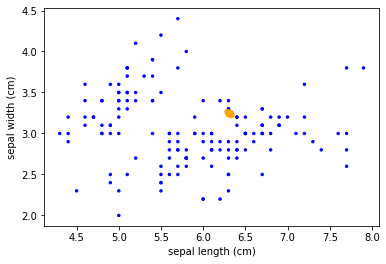

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure()
data_combined = pd.DataFrame(X_train, columns=feature_names)
data_combined['real_vs_fake'] = np.zeros(data_combined.shape[0])
data_combined = pd.concat((data_combined,fake_data ))
data_combined['real_vs_fake'] = data_combined['real_vs_fake'].astype(int)

# a scatter plot comparing num_children and num_pets
x1 = data_combined['sepal length (cm)']
y1 = data_combined['sepal width (cm)']
c = ['orange' if val==1 else 'blue' for val in data_combined['real_vs_fake']]
plt.scatter(x1, y1, c=c, label=c, s=6)

plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
#plt.legend()
plt.show()

In [9]:
scaler.inverse_transform((generator.predict(np.eye( 3,3) )))

array([[6.2987742, 3.2749143, 4.60959  , 1.5402611],
       [6.2858424, 3.2262294, 4.621041 , 1.4708025],
       [6.358848 , 3.241258 , 4.6832542, 1.4717847]], dtype=float32)